<a href="https://colab.research.google.com/github/ErayImamoglu/RNN-w-Word2Vec/blob/main/Word2Vec_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
import time

df=pd.read_csv("/content/train_set_cost_related-_2_.csv")

# Get indices of rows with label 0 and label 1
indices_0 = df[df['CostRelated'] == 0].index
indices_1 = df[df['CostRelated'] == 1].index

# Randomly sample the required number of indices with label 0
random_indices_0 = np.random.choice(indices_0, len(indices_1), replace=False)

# Combine the indices
under_sample_indices = np.concatenate([indices_1, random_indices_0])

# Create the undersampled DataFrame
under_sampled_df = df.loc[under_sample_indices]

# Shuffle the resulting DataFrame for good measure
under_sampled_df = under_sampled_df.sample(frac=1).reset_index(drop=True)

under_sampled_df["CostRelated"] = under_sampled_df["CostRelated"].astype(int)

df=under_sampled_df

df["Text"][1]

'The Supe1vision Contractor shall provide sufficient, qualified and experienced staff to ensure proper site supe1vision of the works during the project duration.'

In [42]:
!pip install gensim
from gensim.models import Word2Vec

In [43]:
#preprocessing
import re
import string

def remove_punct(Text): #punctuationları kaldırmak için bir formül
  translator=str.maketrans("", "", string.punctuation)
  return Text.translate(translator)

df["Text"]=df.Text.map(remove_punct)

df["Text"][1]

'The Supe1vision Contractor shall provide sufficient qualified and experienced staff to ensure proper site supe1vision of the works during the project duration'

In [44]:
#remove stopwords - not kelimesini atılmadan algoritma başarısını karşılaştır.
#pip install ntlk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words("english"))

def remove_stopwords(Text):
  filtered_words=[word.lower() for word in Text.split() if word.lower() not in stop]
  return " ".join(filtered_words)

df["Text"]=df.Text.map(remove_stopwords) # bu olay çıkarıyor

df["Text"][1]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'supe1vision contractor shall provide sufficient qualified experienced staff ensure proper site supe1vision works project duration'

In [45]:
#split dataset into training and validation set
train_size=int(df.shape[0]*0.8)

train_df=df[:train_size]
val_df=df[train_size:]

#split text and labels
train_sentences=train_df.Text.to_numpy()
train_labels=train_df.CostRelated.to_numpy()
val_sentences=val_df.Text.to_numpy()
val_labels=val_df.CostRelated.to_numpy()

print(len(train_sentences))
print(len(val_sentences))

294
74


In [46]:
from collections import Counter

def counter_word(text_col):
  count = Counter()
  for text in text_col.values:
    for word in text.split():
      count[word] += 1
  return count

counter = counter_word(df.Text)
num_unique_words = len(counter)

print(num_unique_words)

1787


In [47]:
#tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Dense

# Tokenize only the training set
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences)  # fit only to training

# Train Word2Vec model ONLY on training data
train_sentences_split = [sentence.split() for sentence in train_sentences]
word2vec = Word2Vec(train_sentences_split, vector_size=100, window=5, min_count=1, sg=0)  # you can change the parameters

# Build embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))  # Assuming embedding dimension is 100
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = word2vec.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:  # word not in word2vec model vocabulary
        pass

print(train_sentences[1])
print(vocab_size)

supe1vision contractor shall provide sufficient qualified experienced staff ensure proper site supe1vision works project duration
1545


In [48]:
train_sequences=tokenizer.texts_to_sequences(train_sentences) #sentences to sequence-indices
val_sequences=tokenizer.texts_to_sequences(val_sentences)     #sentences to sequence-indices

print(train_sentences[1])
print(train_sequences[1])

supe1vision contractor shall provide sufficient qualified experienced staff ensure proper site supe1vision works project duration
[413, 9, 2, 7, 126, 180, 414, 6, 23, 153, 11, 413, 4, 5, 82]


In [49]:
#pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Max number of words in a sequence
max_length =32

train_padded=pad_sequences(train_sequences,maxlen=max_length,padding="post",truncating="post")
val_padded=pad_sequences(val_sequences,maxlen=max_length,padding="post",truncating="post")

print(train_padded[1])

[413   9   2   7 126 180 414   6  23 153  11 413   4   5  82   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [50]:
#check reversing the indices
#flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in tokenizer.word_index.items()])

def decode(sequence):
  return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

print(reverse_word_index)

{1: 'consultant', 2: 'shall', 3: 'contract', 4: 'works', 5: 'project', 6: 'staff', 7: 'provide', 8: 'construction', 9: 'contractor', 10: 'office', 11: 'site', 12: 'experts', 13: 'design', 14: 'services', 15: 'equipment', 16: 'supervision', 17: 'required', 18: 'necessary', 19: 'including', 20: 'client', 21: 'costs', 22: 'support', 23: 'ensure', 24: 'provided', 25: 'review', 26: 'must', 27: 'insurance', 28: 'documents', 29: 'payment', 30: 'accommodation', 31: 'implementation', 32: 'engineer', 33: 'within', 34: 'report', 35: 'assignment', 36: 'accordance', 37: 'plan', 38: 'well', 39: 'local', 40: 'work', 41: 'terms', 42: 'contractors', 43: 'liability', 44: 'responsible', 45: 'vehicles', 46: 'period', 47: 'reports', 48: 'facilities', 49: 'completion', 50: 'provision', 51: 'relevant', 52: 'may', 53: 'appropriate', 54: 'also', 55: 'civil', 56: 'laboratory', 57: 'country', 58: 'included', 59: 'drawings', 60: 'etc', 61: 'part', 62: 'cost', 63: 'following', 64: 'months', 65: 'quality', 66: 'con

In [34]:
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

In [62]:
# LSTM Model
from keras.regularizers import l2
# Define Parameter
n_lstm = 64
drop_lstm = 0.2
reg_lambda = 0.01  # regularization factor

# Define LSTM Model
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=vocab_size,
                         output_dim=100,
                         input_length=max_length,
                         weights=[embedding_matrix],
                         trainable=True))
model_LSTM.add(SpatialDropout1D(drop_lstm))
model_LSTM.add(LSTM(n_lstm, return_sequences=False, kernel_regularizer=l2(reg_lambda)))  # Added regularization here
model_LSTM.add(Dropout(drop_lstm))
model_LSTM.add(layers.Dense(1, activation="sigmoid", kernel_regularizer=l2(reg_lambda)))  # Added regularization here


In [36]:
model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 100)           161200    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 32, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 278,577
Trainable params: 278,577
Non-trainable params: 0
________________________________________________

In [63]:
model_LSTM.compile(loss='binary_crossentropy',
                   optimizer=keras.optimizers.Adam(learning_rate=0.001),
                   metrics=['accuracy'])

In [64]:
from tensorflow.keras.callbacks import EarlyStopping
num_epochs_LSTM=10
early_stop = EarlyStopping(monitor='val_loss', patience=4)
history_LSTM = model_LSTM.fit(train_padded,
                              train_labels,
                              epochs=num_epochs_LSTM,
                              validation_data=(val_padded, val_labels),
                              callbacks=[early_stop],
                              verbose=2)

Epoch 1/10
10/10 - 5s - loss: 2.0138 - accuracy: 0.4796 - val_loss: 1.8393 - val_accuracy: 0.4459 - 5s/epoch - 516ms/step
Epoch 2/10
10/10 - 0s - loss: 1.7255 - accuracy: 0.5170 - val_loss: 1.5834 - val_accuracy: 0.4459 - 246ms/epoch - 25ms/step
Epoch 3/10
10/10 - 0s - loss: 1.4773 - accuracy: 0.5306 - val_loss: 1.3482 - val_accuracy: 0.4730 - 258ms/epoch - 26ms/step
Epoch 4/10
10/10 - 0s - loss: 1.0152 - accuracy: 0.8231 - val_loss: 0.8241 - val_accuracy: 0.9189 - 247ms/epoch - 25ms/step
Epoch 5/10
10/10 - 0s - loss: 0.6813 - accuracy: 0.9592 - val_loss: 0.6581 - val_accuracy: 0.9189 - 244ms/epoch - 24ms/step
Epoch 6/10
10/10 - 0s - loss: 0.6178 - accuracy: 0.9184 - val_loss: 0.6328 - val_accuracy: 0.8919 - 240ms/epoch - 24ms/step
Epoch 7/10
10/10 - 0s - loss: 0.3986 - accuracy: 0.9830 - val_loss: 0.7613 - val_accuracy: 0.8784 - 248ms/epoch - 25ms/step
Epoch 8/10
10/10 - 0s - loss: 0.3078 - accuracy: 0.9932 - val_loss: 0.6570 - val_accuracy: 0.8784 - 273ms/epoch - 27ms/step
Epoch 9/10

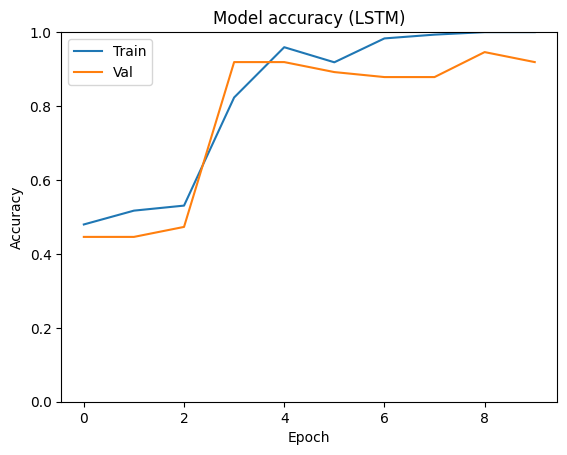

In [65]:
plt.plot(history_LSTM.history["accuracy"])
plt.plot(history_LSTM.history["val_accuracy"])

plt.title('Model accuracy (LSTM)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.ylim([0, 1])  # Set the y-axis limits

plt.show()

3/3 [==============================] - 0s 14ms/step
Validation Accuracy: 0.8648648648648649
Validation Precision: 0.9259259259259259
Validation F1 Score: 0.8333333333333334
Confusion Matrix: 
[[39  2]
 [ 8 25]]


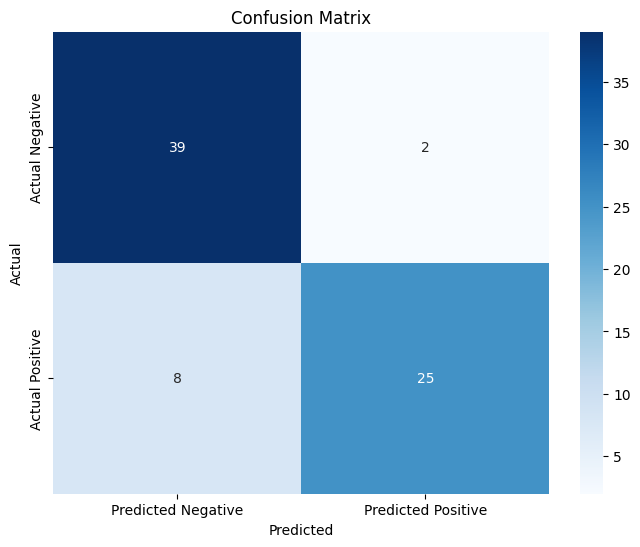

In [61]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the validation set
val_predictions = model_LSTM.predict(val_padded)
val_predictions = [1 if p > 0.5 else 0 for p in val_predictions]

# Calculate Accuracy
accuracy = accuracy_score(val_labels, val_predictions)

# Calculate Precision
precision = precision_score(val_labels, val_predictions)

# Calculate F1 Score
f1 = f1_score(val_labels, val_predictions)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)

print(f"Validation Accuracy: {accuracy}")
print(f"Validation Precision: {precision}")
print(f"Validation F1 Score: {f1}")
print(f"Confusion Matrix: \n{conf_matrix}")

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
